In [1]:
%matplotlib notebook
%load_ext snakeviz
%load_ext autoreload
%autoreload 2
from supplementary.simple_choice_model import hits_gen
from supplementary.simple_choice_model import sim_tools
import ipywidgets as wid

from tqdm import tqdm_notebook
import loc_utils as lut
import vis_utils as vut
import numpy as np
import pandas as pd
import scipy as sp
import contextlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display
colors = ['#43799d', '#cc5b46', '#ffbb00', '#71bc78', '#43799d', '#cc5b46', '#ffbb00', '#71bc78']

@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)

# Introduction

This notebook will introduce an artificial agent that uses a simple decision-making routine in order to choose the next task to interact with. The agent starts in some initial state (some past history of interacting with all tasks) to make the initial decision. Upon choosing a task, the agent "plays" it, gets some feedback (hit or miss), updates its state accordingly and repeats. This closed-loop process involves multiple components that can produce different behaviors over time.

One interesting thing about the tasks that the agent chooses from, is that the probability of getting a positive feedback can change over time depending on the agent's engagement with the task. In other words, the tasks are such that the agent can learn to perform better on them, provided they are learnable. To fully model the closed-loop process we would need a model of learning. However, we can simulate this part of the process with any function that takes time (or experience) on a given task as an argument and returns the probabilities over particualar outcomes (e.g. correct / incorrect). Below, I will use a sigmoid function of a linear function with 1 independent predictor: number of trials on task (so far). Basically:

$$ P(\text{hit} \mid \text{trial}) = \sigma(b_0 + b_1 \text{trial}) = \frac{1}{1 + e^{-(b_0 + b_1 \text{trial})}} $$

where $b_0, b_1$ are free parameters and can differ between tasks. Parameter $b_1$ controls to how rapidly the function increases and $b_0$ corresponds how likely getting a hit is without prior experience with the task (when $\text{trial} = 0$). Below you have an interface to either fit these parameters to our data (or aspects of data), or tweak them as you like. Select the next `code cell` and run it (try `Shift + Enter`, or the Run button from the menu on the top left).

# Generating hits

In [9]:
# %matplotlib notebook
# from supplementary.simple_choice_model import hits_gen as hits
hits_generator = hits_gen.HitsGeneratorGUI(bandits=['1D','I1D','2D','R'], gui=True)

<IPython.core.display.Javascript object>

# Decision-making process

The probability of choosing a task is proportional to the **utility** of that task, and the probabilities are given by the _softmax_ function which normalizes all utilities so that they sum up to one:

$$ p(\text{task}_i) = \frac{e^{u_i/\tau}} {\sum_j e^{u_j/\tau}} $$

Above, $u_i$ is the utility of a particular task $i$, while $j$ indexes the utilities of all tasks, including $i$; $\tau$ is the temperature parameter of the softmax function which controls the stochasticity of the function. As $\tau$ approaches 0, softmax approaches the argmax function.

The agent uses a linear utility function to evaluate each task:

$$ u_{i,t} = \alpha \text{LP}_{i,t} + \beta \text{PC}_{i,t} + \gamma I_{i,t} $$

where $\alpha, \beta, \gamma$ are free parameters, $\text{LP}$ is the learning progress evaluated for task $i$ at time $t$, $\text{PC}$ is its positive feedback expectation (modeled as Percent Correct), and $I$ is the "inertia" variable that equals 1 if task $i$ was played on the previous trial and 0 otheriwse. As long as the agent has these 3 quantities for any task, it can meaningfully assign utility to it. Note that each term is itself a model with its own parameters and structure.

## Learning progress
LP is a quantity that reflects _change_ in learning. In our case it can be both positive and negative change. There are many ways to model LP, but we will use a formulation that does not assume the use of any learning model by the agent, since we have not introduced one. Instead, the agent relies on a finite perfect memory of hits and misses that extends some time in the past. The memory stores the record of outcomes for each tasks and LP is evaluated based on these records. Specifically, the agent takes the absolute difference between the hit rate over some number $m_0$ of most recent trials on a task and the hit rate over some $m_1$ most recent trials right before that (on the same task). In other words, it compares the new performance history to the older performance history to see whether performance is changing or stays the same.

> Closely related to Reward Prediction Error and Temporal Difference Error in simple Q-learning.

## Expected positive feedback
As mentioned before, the expected positive feedback is modeled as a percentage of hits in the record of all trials stored in memory. If the memory size is $M$, then $PC_{i,t}$ is the proportion of hits in $M$ most recent past trials on task $i$. This variable is an operationalization of subjective evaluation of one's mastery of a task. Plain hit rate across M trials is a very simple operationalization and one could consider various models of the judgment of learning (JOL) to describe the process more faithfully. Also note, that LP relies on the computation of hit rate and thus could be closely related to the JOL mechanism.

> Closely related to confidence judgments and JOLs.

## Inertia
Finally, the inertia term is there to make sure that the agent's behavior qualitatively resembles that of a human being. Specifically, it boosts the utility of a task that has been selected a time step prior, which increases the probability of repeating the same task. When humans explore freely, they tend to stay on the same task for some extended period of time before switching to another one (some even played the same task for 250 trials). If there is no incentive for the agent to repeat its selection, it would jump across tasks (seemingly) erratically due to the stochasticity of the decision-making mechanism.

> Inertia is equivalent to switching cost, which can be implemented similarly. Instead of having a vector `[0,1,0,0]` that encodes whether task $i$ at time $t$ was selected on time $t-1$, we could have a vector `[1,0,1,1]` that represents whether the task $i$ at time $t$ is a new one (i.e. requires switching to). Then, a negative parameter would correspond to the size of the switching cost and "discourage" the agent to switch. Additionally, I think, inertia is related to boredom. If there is only inertia, there is nothing to prevent an agent from sticking to the same task forever, if the parameter is strong enough (LP and PC cannot easily overcome it, because they are bounded between 0 and 1). A boredom variable could be such that it increases with time and can eventually tip over the fixed inertia quantity. The relative sensitivities to inertia and boredom can determine how readily the agent switches to something else. Boredom, however, is not simply a function of time spent on the same task and probably interacts with LP, PC and most certainly other factors.

# Simulation

Below, you can simulate and view one or several rounds of free play by running the following code cell. To start a simulation, we need initialize the starting state. We do it by randomly sampling a subject from our data (or from a subset of data). Click "Update initial state" button to sample a new subject. You will see their training trials appear on the top left (black = 1 / hit, white = 0 / miss). This initial state will be used to compute the utilities and start the free-play closed loop. To simulate 250 trials of free play, click the "Simulate" button. You will see the proportion of time spent on each task on the top-right, as well as the agent's actual choices and outcomes across time on the bottom. 

You can interactively change the utility function's free parameters to see how the behavior changes. You can also change the parameters of the `hits_generator`, and/or change the initial state. Be sure to update the initial state by clicking the button and click on 'Simulate' button to see the latest changes. 

Finally, the simulation can include multiple runs (up to 30) on the same input state and parameter values, each resulting in its own trajectory and learning outcomes (self-challenge and test performance, calculated indentically to SC and test score from our data analyses). You can set the number of runs (N) and view different runs individually by setting the 'Run #' slider to a particular run ID. You can also view the learning outcomes of all runs (gray circles) and their average (solid black circle) in the figure below the controls called **sim^2** (the square marker shows you which run you are currently viewing in the top panels).

<IPython.core.display.Javascript object>


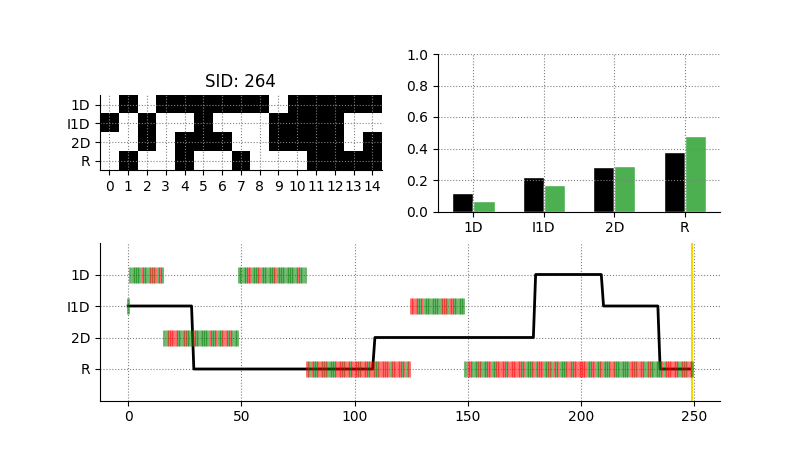

Output()

In [39]:
# from supplementary.simple_choice_model import sim_tools
alpha_, beta_, gamma_, theta_, tau_ = [-1,1], [-1,1], [0,1], [-1, 0], [1, 10]
simulator = sim_tools.Simulator(nb_trials=250, hits_generator=hits_generator, 
                                controls=True, live=False, max_rolls=50,
                                alpha=alpha_, beta=beta_, gamma=gamma_, theta=theta_, tau=tau_)


# Estimating parameters

## Choosing an objective function
The interactive simulations above are based on a model of the decision-making process, which can be broken down into two major components organized hierarchically:

1. **Choice model**. The choice model is at the highest level of the process. It is the mechanism that determines how particular choices are made. In our case, it takes a form of the softmax function, which maps task utilities to their probabilities in a particular way.
2. **Utility model**. At a lower level of the decision-making process is evaluation of utility. In our formulation, utility evaluation is a function that determines subjective value of a task. Formally, it is a linear combination of several quantities assumed to influence utility.

We would like to show that a particular instance of the utility function, the one that linearly combines LP, PC, and I (as we have defined them), might be an accurate account of the actual evaluative process. Ideally, we would want to operationalize and measure subjective utility, so that the utility function can be fit directly to the data that it models. The fitted parameters could then be used to simulate artificial utility evaluations and compared to their real counterparts. The closest thing we have to real subjective evaluations is task choices presumably made on the basis of utility.

Therefore, we can fit the utility model to choice data, by using the choice model as a link function

<IPython.core.display.Javascript object>


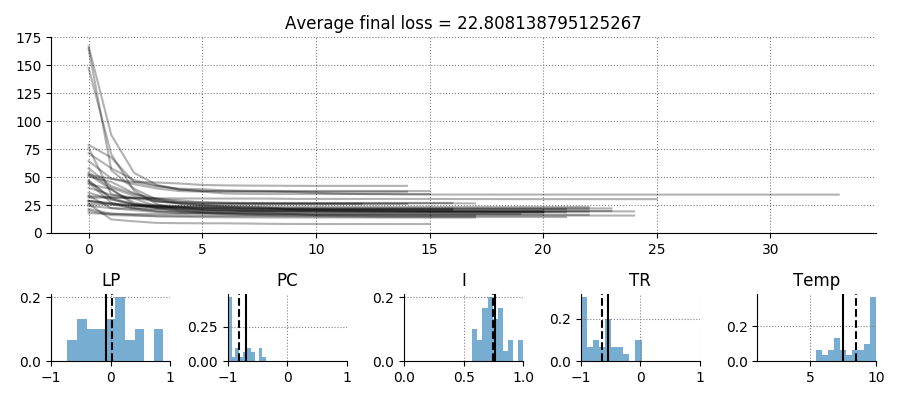

True params: [-0.08297961 -0.69255569  0.76634179 -0.5409149   7.49206847]
Fitted params: [ 0.021 -0.812  0.751 -0.642  8.458]


In [42]:
def neg_log_likelihood(params, *args):
    a, b, c, d, t = params
    LP, PC, I, TR, choices = args
    U = a*LP + b*PC + c*I + d*TR
    P = (np.exp(U * t).T / np.sum(np.exp(U * t), axis=1)).T
    logP = np.log(P[choices.astype(bool)])
    logL = np.sum(logP, axis=0)
    return -logL

params = np.array((simulator.alpha.value,simulator.beta.value,simulator.gamma.value,
        simulator.theta.value,simulator.tau.value))

alpha_bounds = [-1, 1]
beta_bounds  = [-1, 1]
gamma_bounds = [0, 1]
theta_bounds = [-1, 1]
tau_bounds   = [1, 10]

bounds = (alpha_bounds, beta_bounds, gamma_bounds, theta_bounds, tau_bounds)

fig = plt.figure('Sanity check', figsize=[9,4])
gs = GridSpec(3, 5)
ax = vut.pretty(fig.add_subplot(gs[:-1, :]))
N_runs = 30
estimates = np.zeros([N_runs, params.size])
losses = np.zeros(N_runs)
for seed in range(N_runs):
    loss_hist = []
    with temp_seed(seed):
        tot, pcs, lps, trs, choices, hits, util = simulator.simulate(alpha=simulator.alpha.value, 
                                                                     beta=simulator.beta.value,
                                                                     gamma=simulator.gamma.value,
                                                                     theta=simulator.theta.value,
                                                                     tau=simulator.tau.value)
    pcs = np.stack(pcs, axis=0)[:-1]
    lps = np.stack(lps, axis=0)[:-1]
    choice_inds = np.array(choices).astype(int)

    inertia = np.zeros_like(pcs)
    inds = np.arange(1, inertia.shape[0])
    inertia[inds, choice_inds[:-1]] = 1

    choices = np.zeros_like(pcs)
    inds = np.arange(choices.shape[0])
    choices[inds, choice_inds] = 1
    
    time_alloc = (choices.cumsum(axis=0) + 15)
    trs = (time_alloc.T / time_alloc.sum(axis=1)).T

    data = (lps, pcs, inertia, trs, choices)
    guess = sim_tools.rand_params(bounds)
    x, f, d = sp.optimize.fmin_l_bfgs_b(func=neg_log_likelihood, x0=guess, args=data,
                                        approx_grad=True, disp=True, bounds=bounds,
                                        callback=lambda xk: loss_hist.append([xk, neg_log_likelihood(xk, *data)]))

    estimates[seed-1, :] = x
    losses[seed-1] = f
    ax.plot([xk for _, xk in loss_hist], color='k', alpha=.3)
ax.set_title('Average final loss = {}'.format(losses.mean()))

names = 'LP,PC,I,TR,Temp'.split(',')
for i, p in enumerate(estimates.T):
    ax = vut.pretty(fig.add_subplot(gs[-1, i]))
    bins = np.linspace(bounds[i],20)
    ax.hist(p, weights=np.ones_like(p)/p.size, alpha=.6)
    ax.axvline(params[i], c='k')
    ax.axvline(p.mean(), c='k', ls='--')
    ax.set_xlim(bounds[i])
    ax.set_title(names[i])
    
fig.tight_layout()
np.set_printoptions(suppress=True)
print('True params:', params)
print('Fitted params:', np.around(estimates.mean(axis=0), 3))

In [ ]:
def neg_log_likelihood(params, *args):
    a, b, c, d, t = params
    LP, PC, I, TR, choices = args
    U = a*LP + b*PC + c*I + d*TR
    P = (np.exp(U * t).T / np.sum(np.exp(U * t), axis=1)).T
    logP = np.log(P[choices.astype(bool)])
    logL = np.sum(logP, axis=0)
    return -logL

alpha_bounds = [-.1, 1]
beta_bounds  = [-1, 1]
gamma_bounds = [0, 1]
theta_bounds = [-1, 0]
tau_bounds   = [1, 50]

with tqdm_notebook(total=2) as tau_UB_bar:
    for tau_upper_bound in [10, 50]:
        fit_data = []
        tau_bounds   = [1, tau_upper_bound]
        tau_UB_bar.update()
        with tqdm_notebook(total=7**5, leave=False) as params_bar:
            for alpha in np.linspace(alpha_bounds[0], alpha_bounds[1], 7):
                for beta in np.linspace(beta_bounds[0], beta_bounds[1], 7):
                    for gamma in np.linspace(gamma_bounds[0], gamma_bounds[1], 7):
                        for theta in np.linspace(theta_bounds[0], theta_bounds[1], 7):
                            for tau in np.linspace(tau_bounds[0], tau_bounds[1], 7):
                                params_bar.update()
                                params = np.array((alpha, beta,gamma,theta,tau))
                                bounds = (alpha_bounds, beta_bounds, gamma_bounds, theta_bounds, tau_bounds)
                                N_runs = 20
                                estimates = np.zeros([N_runs, params.size])
                                losses = np.zeros(N_runs)
                                with tqdm_notebook(total=N_runs, leave=False) as runs_bar:
                                    for seed in range(N_runs):
                                        with temp_seed(seed):
                                            tot, pcs, lps, trs, choices, hits, util = simulator.simulate(
                                                alpha = alpha,                                
                                                beta = beta,                             
                                                gamma = gamma,                             
                                                theta = theta,                          
                                                tau = tau)

                                        pcs = np.stack(pcs, axis=0)[:-1]
                                        lps = np.stack(lps, axis=0)[:-1]
                                        choice_inds = np.array(choices).astype(int)

                                        inertia = np.zeros_like(pcs)
                                        inds = np.arange(1, inertia.shape[0])
                                        inertia[inds, choice_inds[:-1]] = 1

                                        choices = np.zeros_like(pcs)
                                        inds = np.arange(choices.shape[0])
                                        choices[inds, choice_inds] = 1

                                        time_alloc = (choices.cumsum(axis=0) + 15)
                                        trs = (time_alloc.T / time_alloc.sum(axis=1)).T

                                        data = (lps, pcs, inertia, trs, choices)
                                        guess = sim_tools.rand_params(bounds)
                                        x, f, d = sp.optimize.fmin_l_bfgs_b(func=neg_log_likelihood, x0=guess, args=data,
                                                                            approx_grad=True, bounds=bounds)

                                        estimates[seed-1, :] = x
                                        losses[seed-1] = f
                                        runs_bar.update()
                                    fit_data.append([losses.mean()]+estimates.mean(axis=0).tolist()+params.tolist()+[tau_upper_bound])

            fit_data = np.stack(fit_data, axis=0)
            colnames = 'mean_loss,alpha,beta,gamma,theta,tau,*alpha*,*beta*,*gamma*,*theta*,*tau*,tau_UB'.split(',')
            pd.DataFrame.from_dict(
                data = dict(zip(colnames, fit_data.T))
            ).to_csv(path_or_buf='loss_data_{}'.format(tau_upper_bound), 
                     float_format='%.5f', columns=colnames, header=True, 
                     index=False)

In [ ]:
def DKL_loss(params, *args):
    a, b, c, d, t = params
    sids, data_beg, data_mid, data_end, init_data, simhits = args
    
    choices_beg = []
    choices_mid = []
    choices_end = []
    for i, sid in enumerate(sids):
        choices = sim_tools.simple_simulation(init_state=init_data[i, :, :], 
                                              win1=10, win2=9, N=250, 
                                              hits = simhits[i, :, :], 
                                              alpha=a, beta=b, 
                                              gamma=c, theta=d, 
                                              tau=t)
        choices_beg.append(np.eye(4)[choices[:10].astype(int)])
        choices_mid.append(np.eye(4)[choices[:250//2].astype(int)])
        choices_end.append(np.eye(4)[choices.astype(int)])
    choices_beg = np.stack(choices_beg).mean(axis=0).mean(axis=0)
    choices_mid = np.stack(choices_mid).mean(axis=0).mean(axis=0)
    choices_end = np.stack(choices_end).mean(axis=0).mean(axis=0)
    DKL_beg = sp.special.kl_div(data_beg, choices_beg).sum()
    DKL_mid = sp.special.kl_div(data_mid, choices_mid).sum()
    DKL_end = sp.special.kl_div(data_end, choices_end).sum()
    
    loss = DKL_end
    return loss

N_runs = 20
c1, c2, c3 = [], [], []

for seed in range(N_runs):
    with temp_seed(seed):
        tot, pcs, lps, trs, choices, hits, util = simulator.simulate(alpha=simulator.alpha.value, 
                                                                     beta=simulator.beta.value,
                                                                     gamma=simulator.gamma.value,
                                                                     theta=simulator.theta.value,
                                                                     tau=simulator.tau.value)
    pcs = np.stack(pcs, axis=0)[:-1]
    lps = np.stack(lps, axis=0)[:-1]
    choice_inds = np.array(choices).astype(int)

    inertia = np.zeros_like(pcs)
    inds = np.arange(1, inertia.shape[0])
    inertia[inds, choice_inds[:-1]] = 1

    choices = np.zeros_like(pcs)
    inds = np.arange(choices.shape[0])
    choices[inds, choice_inds] = 1
    
    c1.append(choices[:10, :])
    c2.append(choices[:choices.shape[0]//2, :])
    c3.append(choices)


c1 = np.stack(c1, axis=0).mean(axis=0).mean(0)
c2 = np.stack(c2, axis=0).mean(axis=0).mean(0)
c3 = np.stack(c3, axis=0).mean(axis=0).mean(0)


data_dict = {'grp': [], 'ntm': [], 'loss': [], 'alpha': [], 'beta': [], 'gamma': [], 'tau': []}
N_trials = 250

bounds = ([-1,1],[-1,1],[0,1],[-1,0],[1,50])
init_guess = sim_tools.rand_params(bounds)

hits_params = hits_gen.get_parametric(grp=0, ntm=3)
trials = np.arange(N_trials) + 1
probs = np.stack([1 / (1 + np.exp(-(hits_params[tid][0] + hits_params[tid][1]*trials))) for tid in [1,2,3,4]], axis=1)
simhits = (np.random.rand(N_runs, N_trials, 4) <= probs).astype(int)
sids = np.array([212 for run in range(N_runs)])
init_data = sim_tools.get_multiple_sids(sids)
data = (sids, c1, c2, c3, init_data, simhits)

x, f, d = sp.optimize.fmin_l_bfgs_b(func=DKL_loss, x0=init_guess, args=data,
                                    approx_grad=True, disp=False, bounds=bounds)

print((simulator.alpha.value,simulator.beta.value,simulator.gamma.value,
        simulator.theta.value,simulator.tau.value))
print(x)